In [ ]:
!pip install cellpose-plus[gui]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 10.2 MB/s eta 0:00:00


In [ ]:
### If you need to get some demo samples
!wget 'https://raw.githubusercontent.com/ITMO-MMRM-lab/cellpose/main/cellpose/resources/4-2-20x_Image020_Properties.xml'
!wget 'https://github.com/ITMO-MMRM-lab/cellpose/raw/main/cellpose/resources/4-2-20x_Image020_ch00.tif'

--2024-07-17 13:03:52--  https://raw.githubusercontent.com/ITMO-MMRM-lab/cellpose/main/cellpose/resources/4-2-20x_Image020_Properties.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13161 (13K) [text/plain]
Saving to: ‘4-2-20x_Image020_Properties.xml’

4-2-20x_Image020_Pr 100%[===================>]  12.85K  --.-KB/s    in 0s      

2024-07-17 13:03:52 (126 MB/s) - ‘4-2-20x_Image020_Properties.xml’ saved [13161/13161]

--2024-07-17 13:03:52--  https://github.com/ITMO-MMRM-lab/cellpose/raw/main/cellpose/resources/4-2-20x_Image020_ch00.tif
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ITMO-MM

In [ ]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import diplib as dip

from cellpose import core, utils, io, models, metrics, gui
from cellpose.gui import features, symmetry
from cellpose.gui import io as gui_io
from glob import glob
from natsort import natsorted
from scipy import ndimage
from PIL import Image, ImageDraw, ImageFont
from scipy.spatial import Voronoi, voronoi_plot_2d

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Wed Jul 17 13:03:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              11W /  7

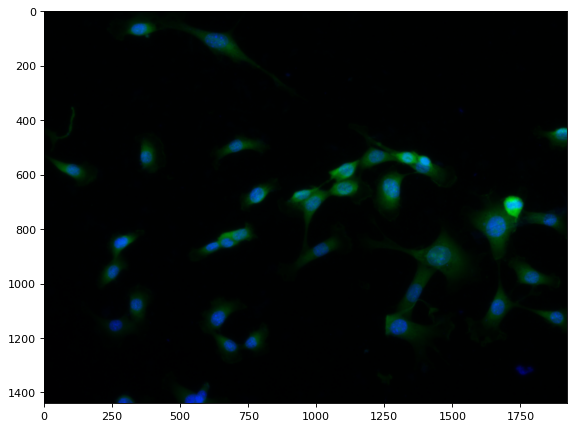

In [ ]:
test_image_name = "4-2-20x_Image020_ch00.tif"
test_image = io.imread(test_image_name)
fig = plt.figure(figsize=(20, 14), dpi=80)

ax = fig.add_subplot(2, 1, 1)
ax.imshow(test_image)

plt.show()

In [ ]:
### Define models per type of object to segment

initial_model_cyto = 'cyto3'
initial_model_nuclei = 'nuclei'

# model_cyto = models.CellposeModel(gpu=use_GPU, model_type=initial_model_cyto)
# model_nuclei = models.CellposeModel(gpu=use_GPU, model_type=initial_model_nuclei)

model_cyto = models.Cellpose(gpu=use_GPU, model_type=initial_model_cyto)
model_nuclei = models.Cellpose(gpu=use_GPU, model_type=initial_model_nuclei)

100%|██████████| 25.3M/25.3M [00:01<00:00, 22.1MB/s]
100%|██████████| 3.54k/3.54k [00:00<00:00, 2.84MB/s]
100%|██████████| 25.3M/25.3M [00:01<00:00, 21.9MB/s]
100%|██████████| 3.54k/3.54k [00:00<00:00, 2.75MB/s]


In [ ]:
### OPTIONAL: Cyto model to calibrate diameter for cytos and nuclei

def calc_diams(calib_model, imgs, seg_channels):
    diams, _ = calib_model.sz.eval(imgs.copy(), channels=seg_channels)
    diams = np.maximum(5.0, diams)
    return round(diams, 1)
    # diams = [round(diam, 1) for diam in diams]
    # return diams

cyto_calib_model = models.Cellpose(gpu=use_GPU, model_type="cyto")

diam_cyto = calc_diams(cyto_calib_model, test_image, [2, 3])
diam_nuclei = calc_diams(cyto_calib_model, test_image, [3, 0])

100%|██████████| 25.3M/25.3M [00:01<00:00, 22.1MB/s]
100%|██████████| 5.23k/5.23k [00:00<00:00, 15.4MB/s]


In [ ]:
print("Estimated cyto diam: ", diam_cyto)
print("Estimated nuclei diam: ", diam_nuclei)

Estimated cyto diam:  82.7
Estimated nuclei diam:  46.3


In [ ]:
### Cyto segmentation

channel1 = 2 # 0 - Grayscale, 3 - Blue, 2 - Green, 1 - Red
channel2 = 3 # 0 - None, 3 - Blue, 2 - Green, 1 - Red

masks_cyto, flows_cyto, styles_cyto, diams_cyto = model_cyto.eval(test_image,
                                                                      channels = [channel1, channel2],
                                                                      diameter = diam_cyto, # None,
                                                                      flow_threshold = 0.4,
                                                                      cellprob_threshold = 0.0)

### Nuclei segmentation

channel1 = 3 # 0 - Grayscale, 3 - Blue, 2 - Green, 1 - Red
channel2 = 0 # 0 - None, 3 - Blue, 2 - Green, 1 - Red

masks_nuclei, flows_nuclei, styles_nuclei, diams_nuclei = model_nuclei.eval(test_image,
                                                                          channels = [channel1, channel2],
                                                                          diameter = diam_nuclei, # None,
                                                                          flow_threshold = 0.4,
                                                                          cellprob_threshold = 0.0)

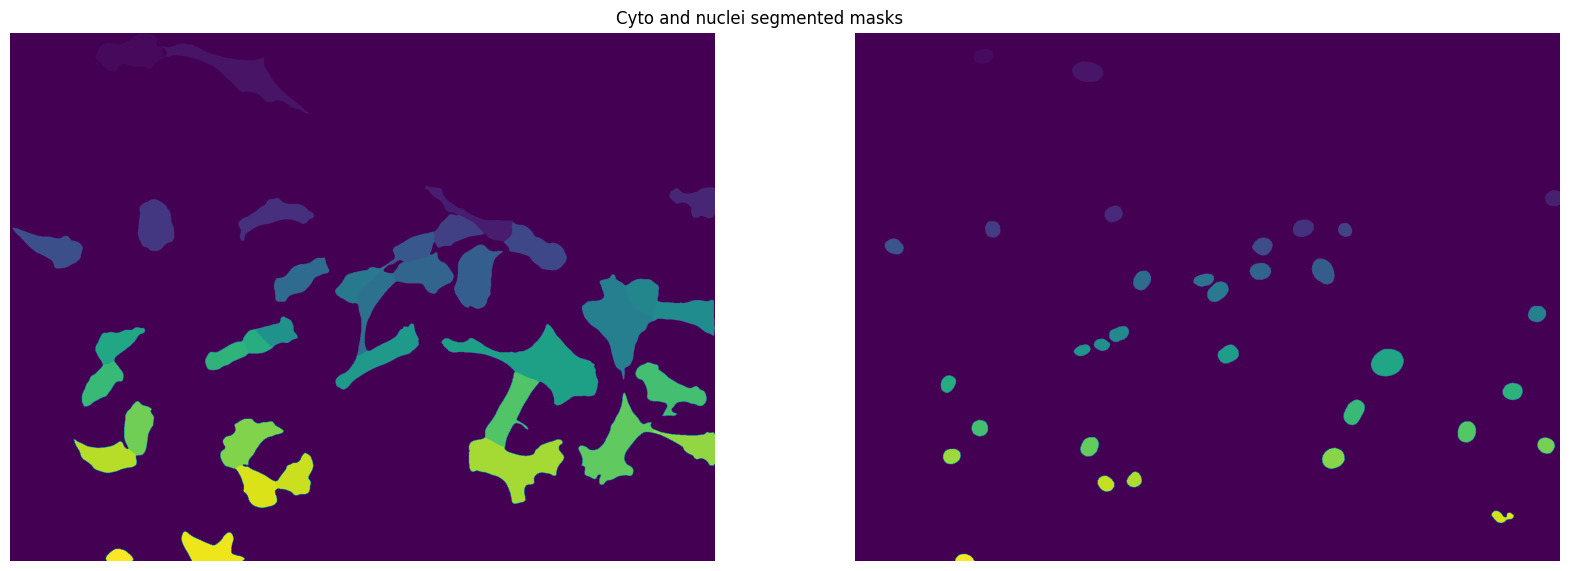

In [ ]:
### Plot cyto and nuclei masks

masks = [masks_cyto, masks_nuclei]

fig, axs = plt.subplots(1, 2, figsize=(20, 14))
fig.suptitle("Cyto and nuclei segmented masks", y=0.7)
for i, ax in enumerate(axs.flat):
    ax.imshow(masks[i])
    ax.axis('off')


In [ ]:
### Initialize FeatureExtraction class and define features

class_features = features.FeatureExtraction()
custom_features = ["Center", "SolidArea", "Roundness"]

downloading font


100%|██████████| 739k/739k [00:00<00:00, 42.7MB/s]


In [ ]:
### Create an object to use it as an envelope for attributes

class Object(object):
    pass

gui_self = Object()
gui_self.calcSize = "SolidArea" in custom_features
gui_self.calcRound = "Roundness" in custom_features
gui_self.px_to_mm = gui_io._get_image_size(os.path.abspath(test_image_name)) # 0.324 # Should be calculated according the Properties file from the microscope
gui_self.px_to_mm

0.324

In [ ]:
### Get features from cyto and nuclei masks

main_metrics, center_coords_main = class_features.get_metrics(masks_cyto, custom_features, gui_self)
size_cells_main, round_cells_main = main_metrics

secondary_metrics, center_coords_secondary = class_features.get_metrics(masks_nuclei, custom_features, gui_self)
size_cells_secondary, round_cells_secondary = secondary_metrics

In [ ]:
### Extract ratio

ratio_cells, center_coords_ratio, indices_cyto_nuclei = class_features.matched_indices(masks_cyto,
                                                                                       masks_nuclei,
                                                                                       size_cells_main,
                                                                                       size_cells_secondary,
                                                                                       center_coords_main)
output_csv_ratio = [[index_cyto_nuclei[0], index_cyto_nuclei[1]] for index_cyto_nuclei in indices_cyto_nuclei]

# Extract colormaps

## Cyto colormaps

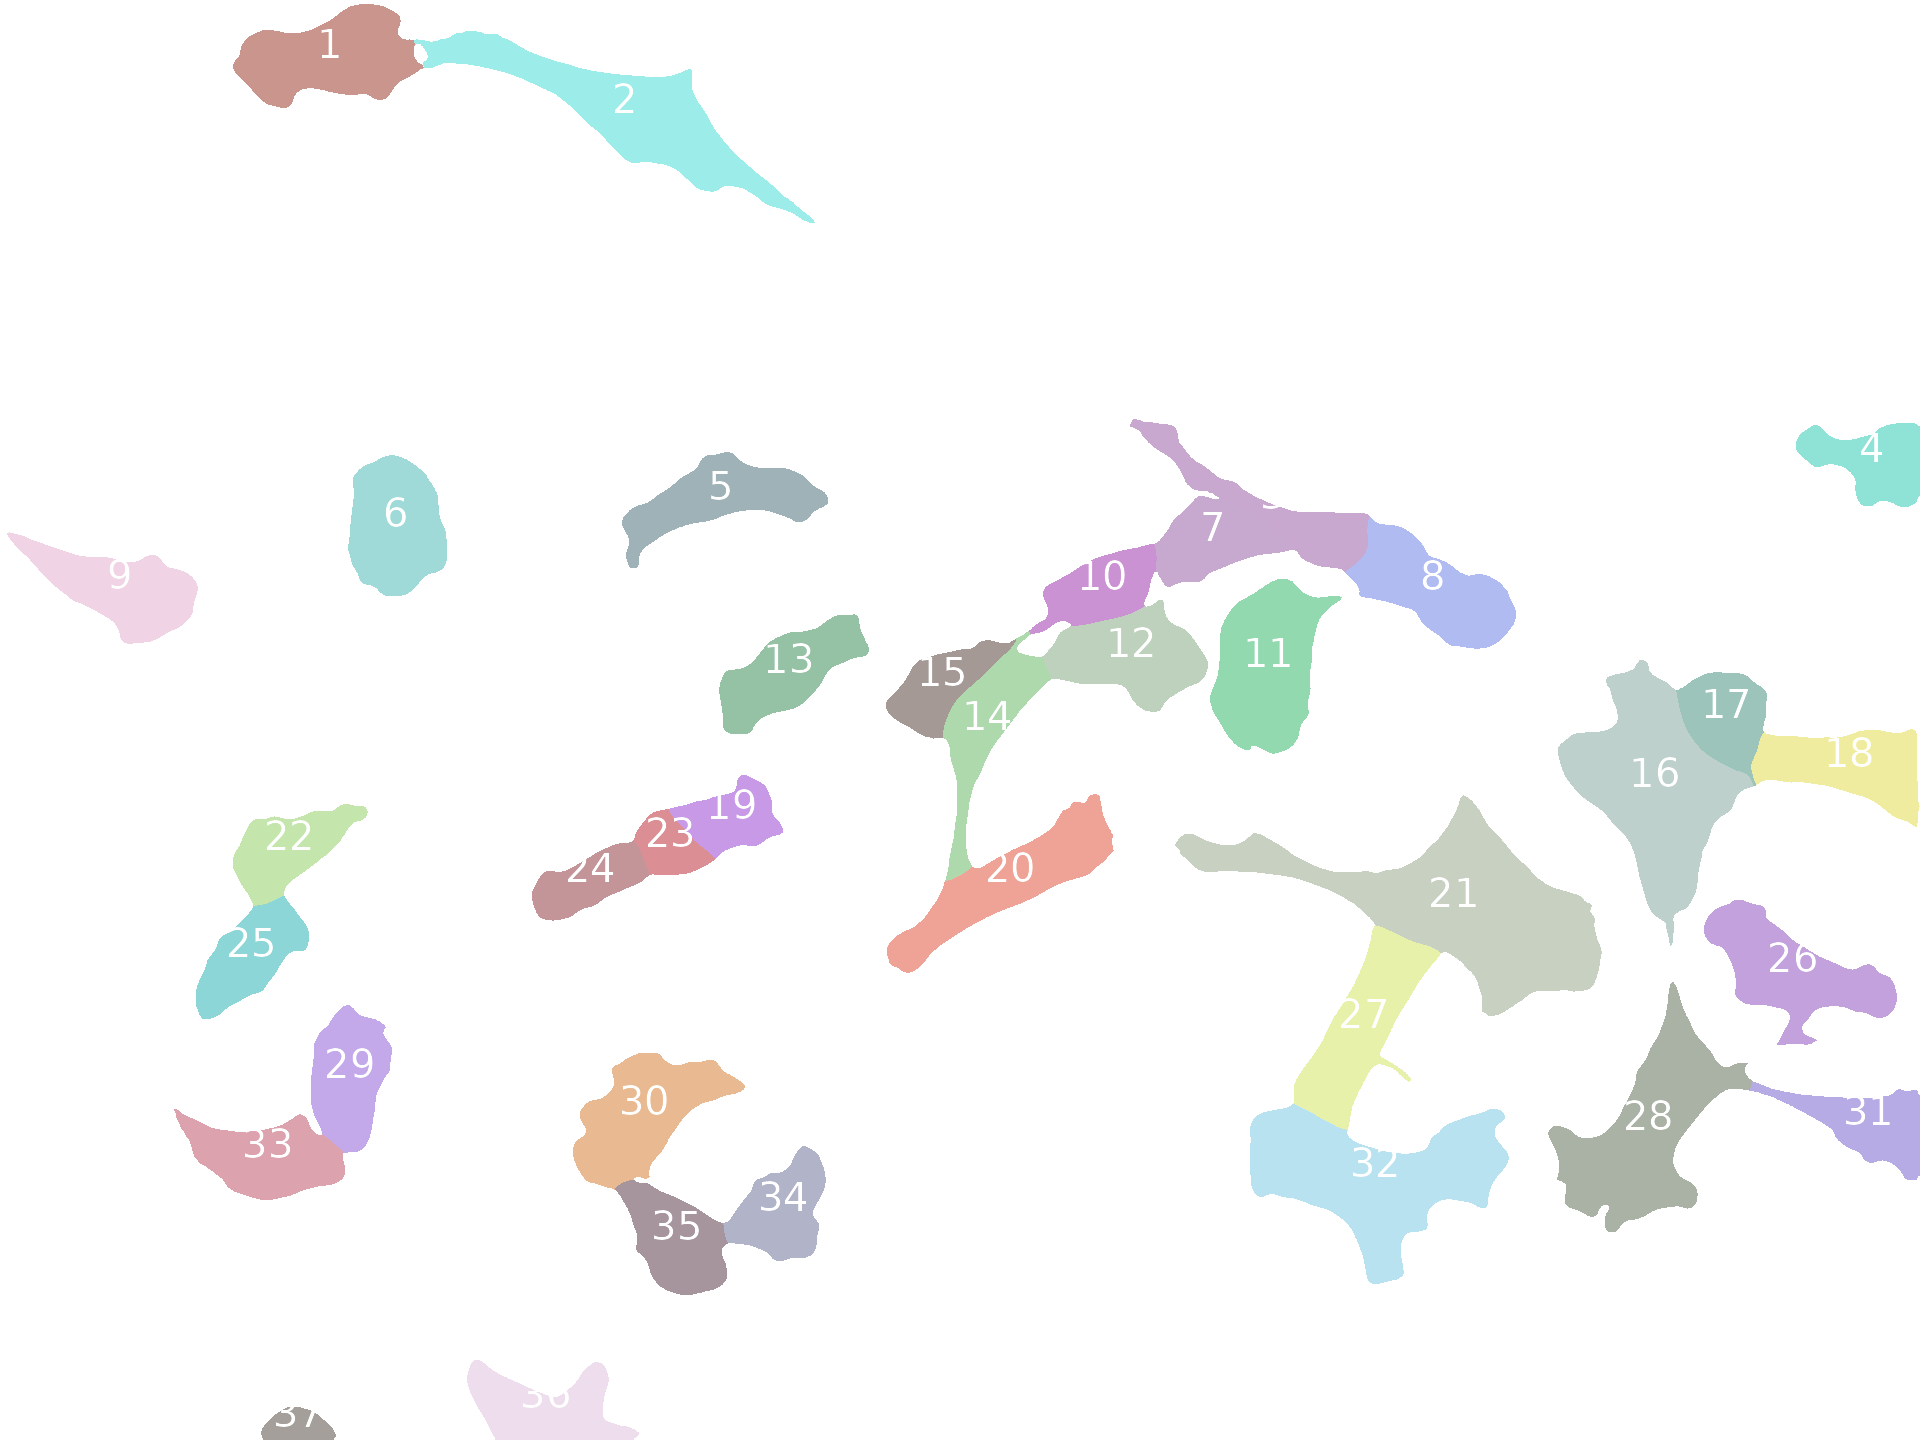

In [ ]:
### Index colormap for cyto

cyto_colormap_mask = Image.fromarray(class_features.create_colormap_mask(masks_cyto))
im_cyto_masks = class_features.mask_indexing(cyto_colormap_mask, center_coords_main)
im_cyto_masks

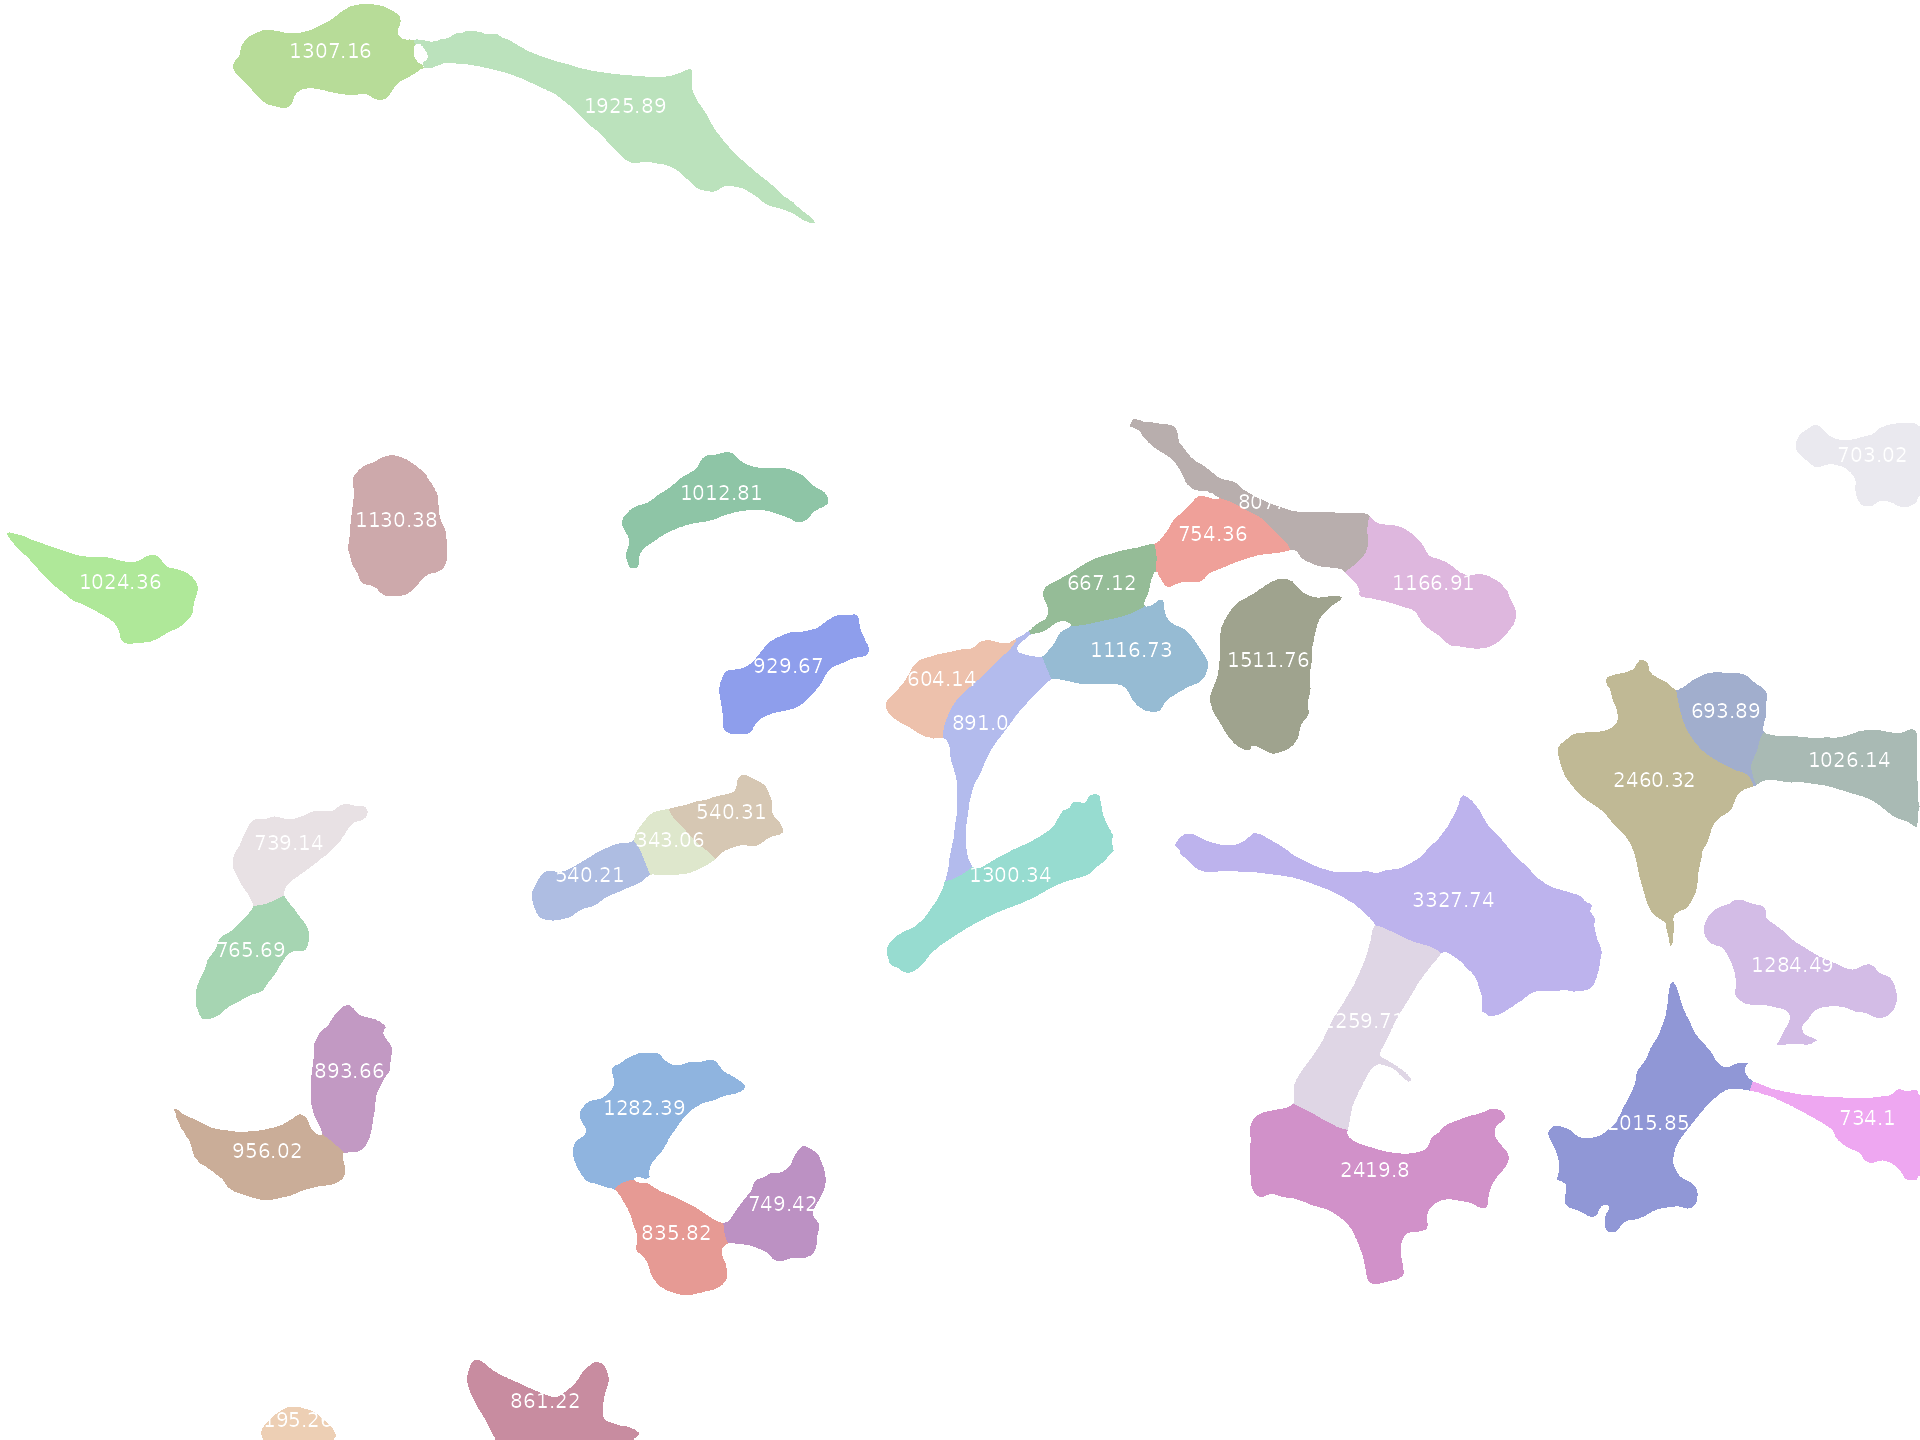

In [ ]:
### Area colormap for cyto

im_cyto_area_masks = Image.fromarray(class_features.create_colormap_mask(masks_cyto))
im_cyto_size_labeled = class_features.image_labeling(im_mask=im_cyto_area_masks, im_labels=size_cells_main, coords=center_coords_main)
im_cyto_size_labeled

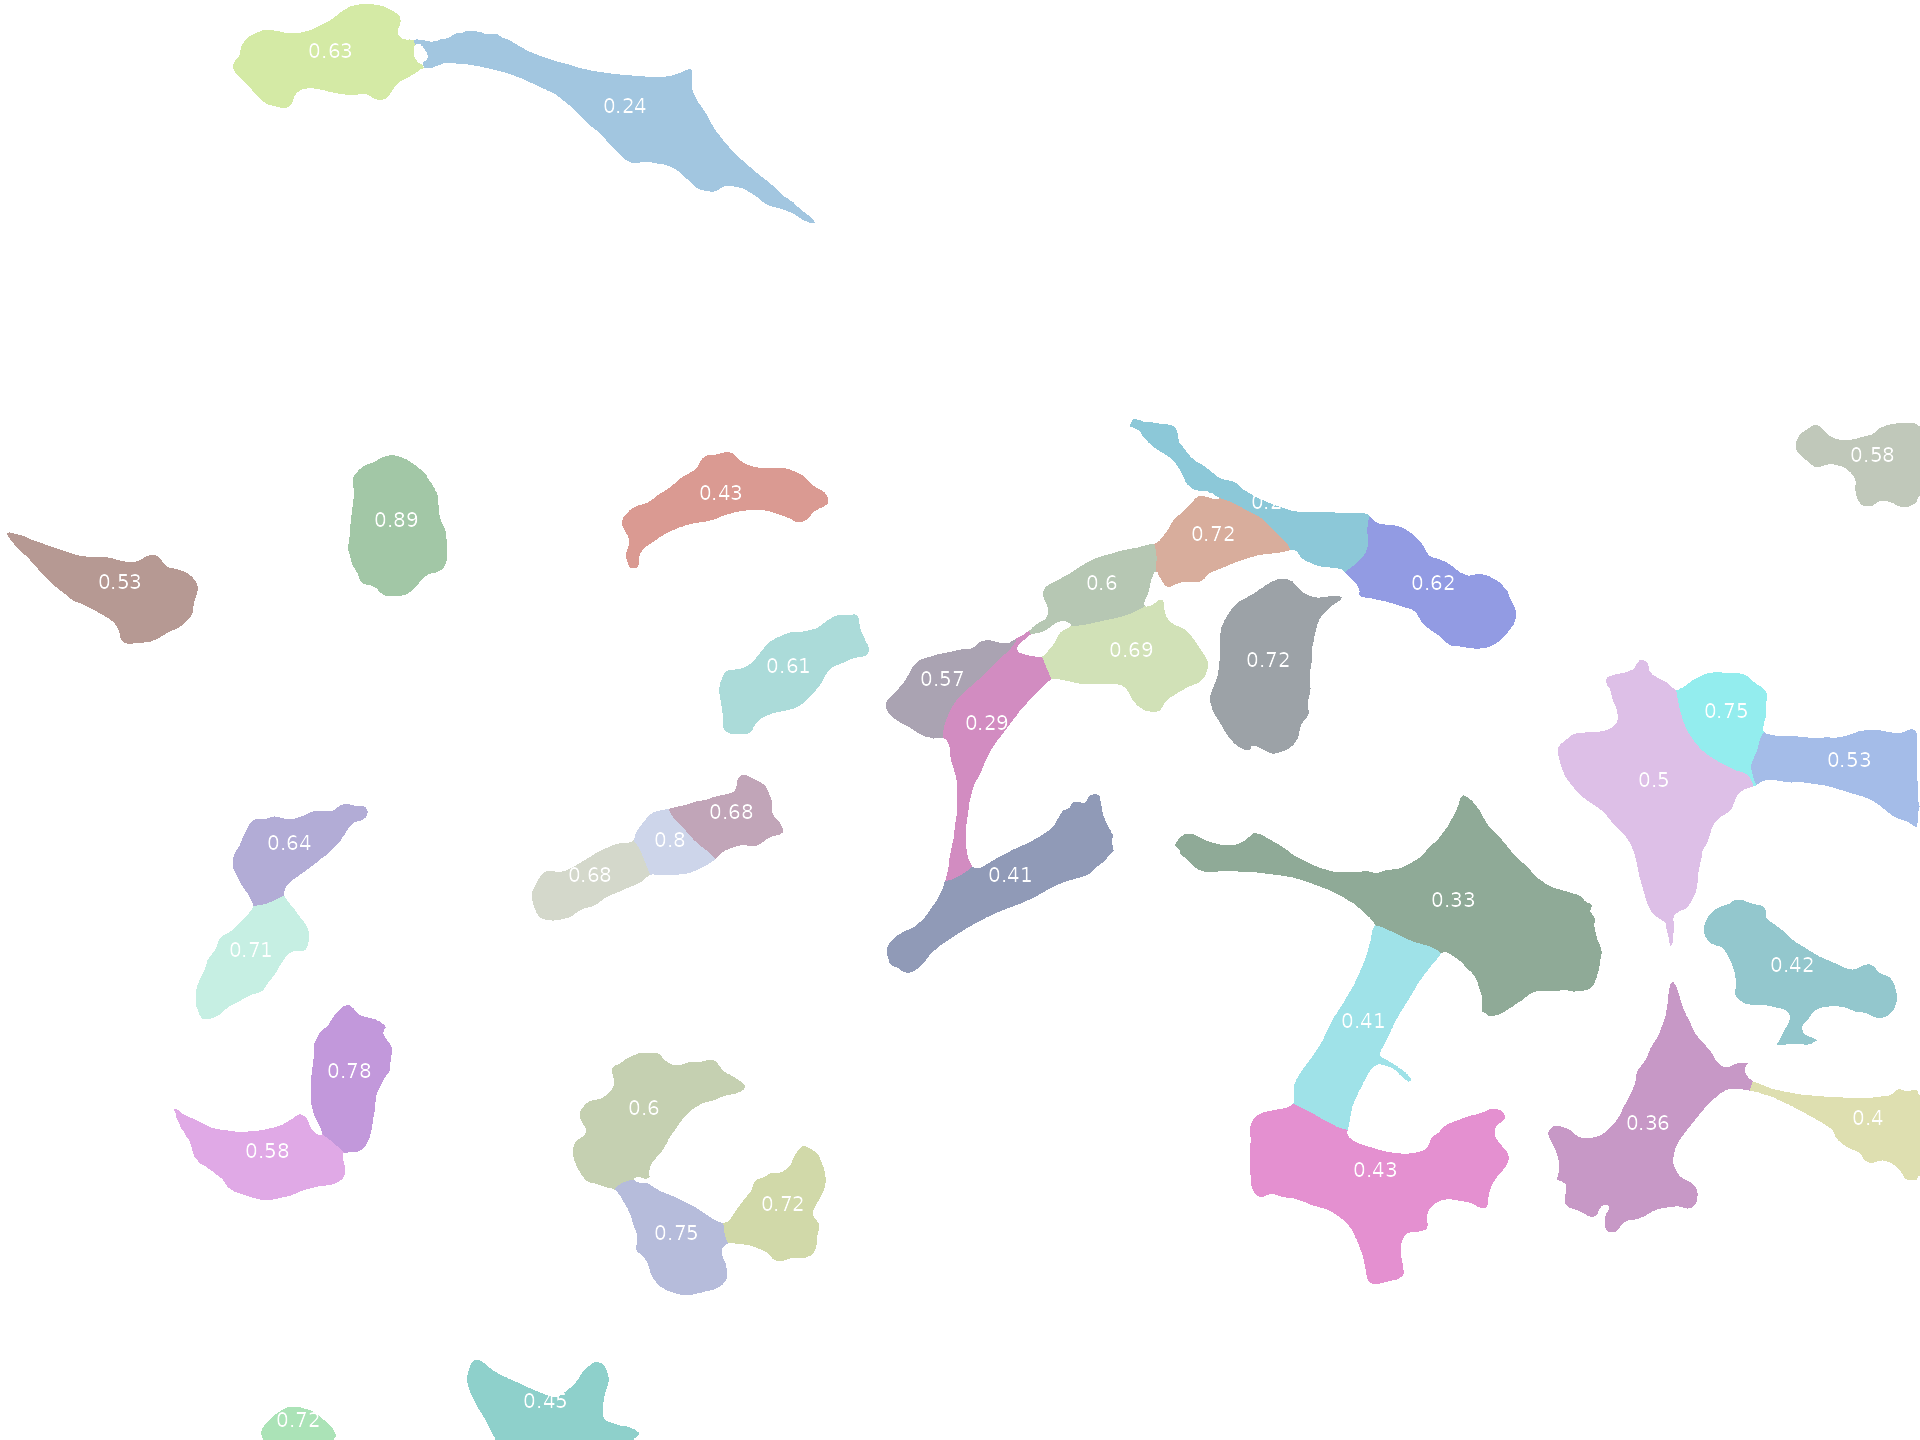

In [ ]:
### Roundness colormap for cyto

im_cyto_roundness_masks = Image.fromarray(class_features.create_colormap_mask(masks_cyto))
im_cyto_roundness_labeled = class_features.image_labeling(im_mask=im_cyto_roundness_masks, im_labels=round_cells_main, coords=center_coords_main)
im_cyto_roundness_labeled

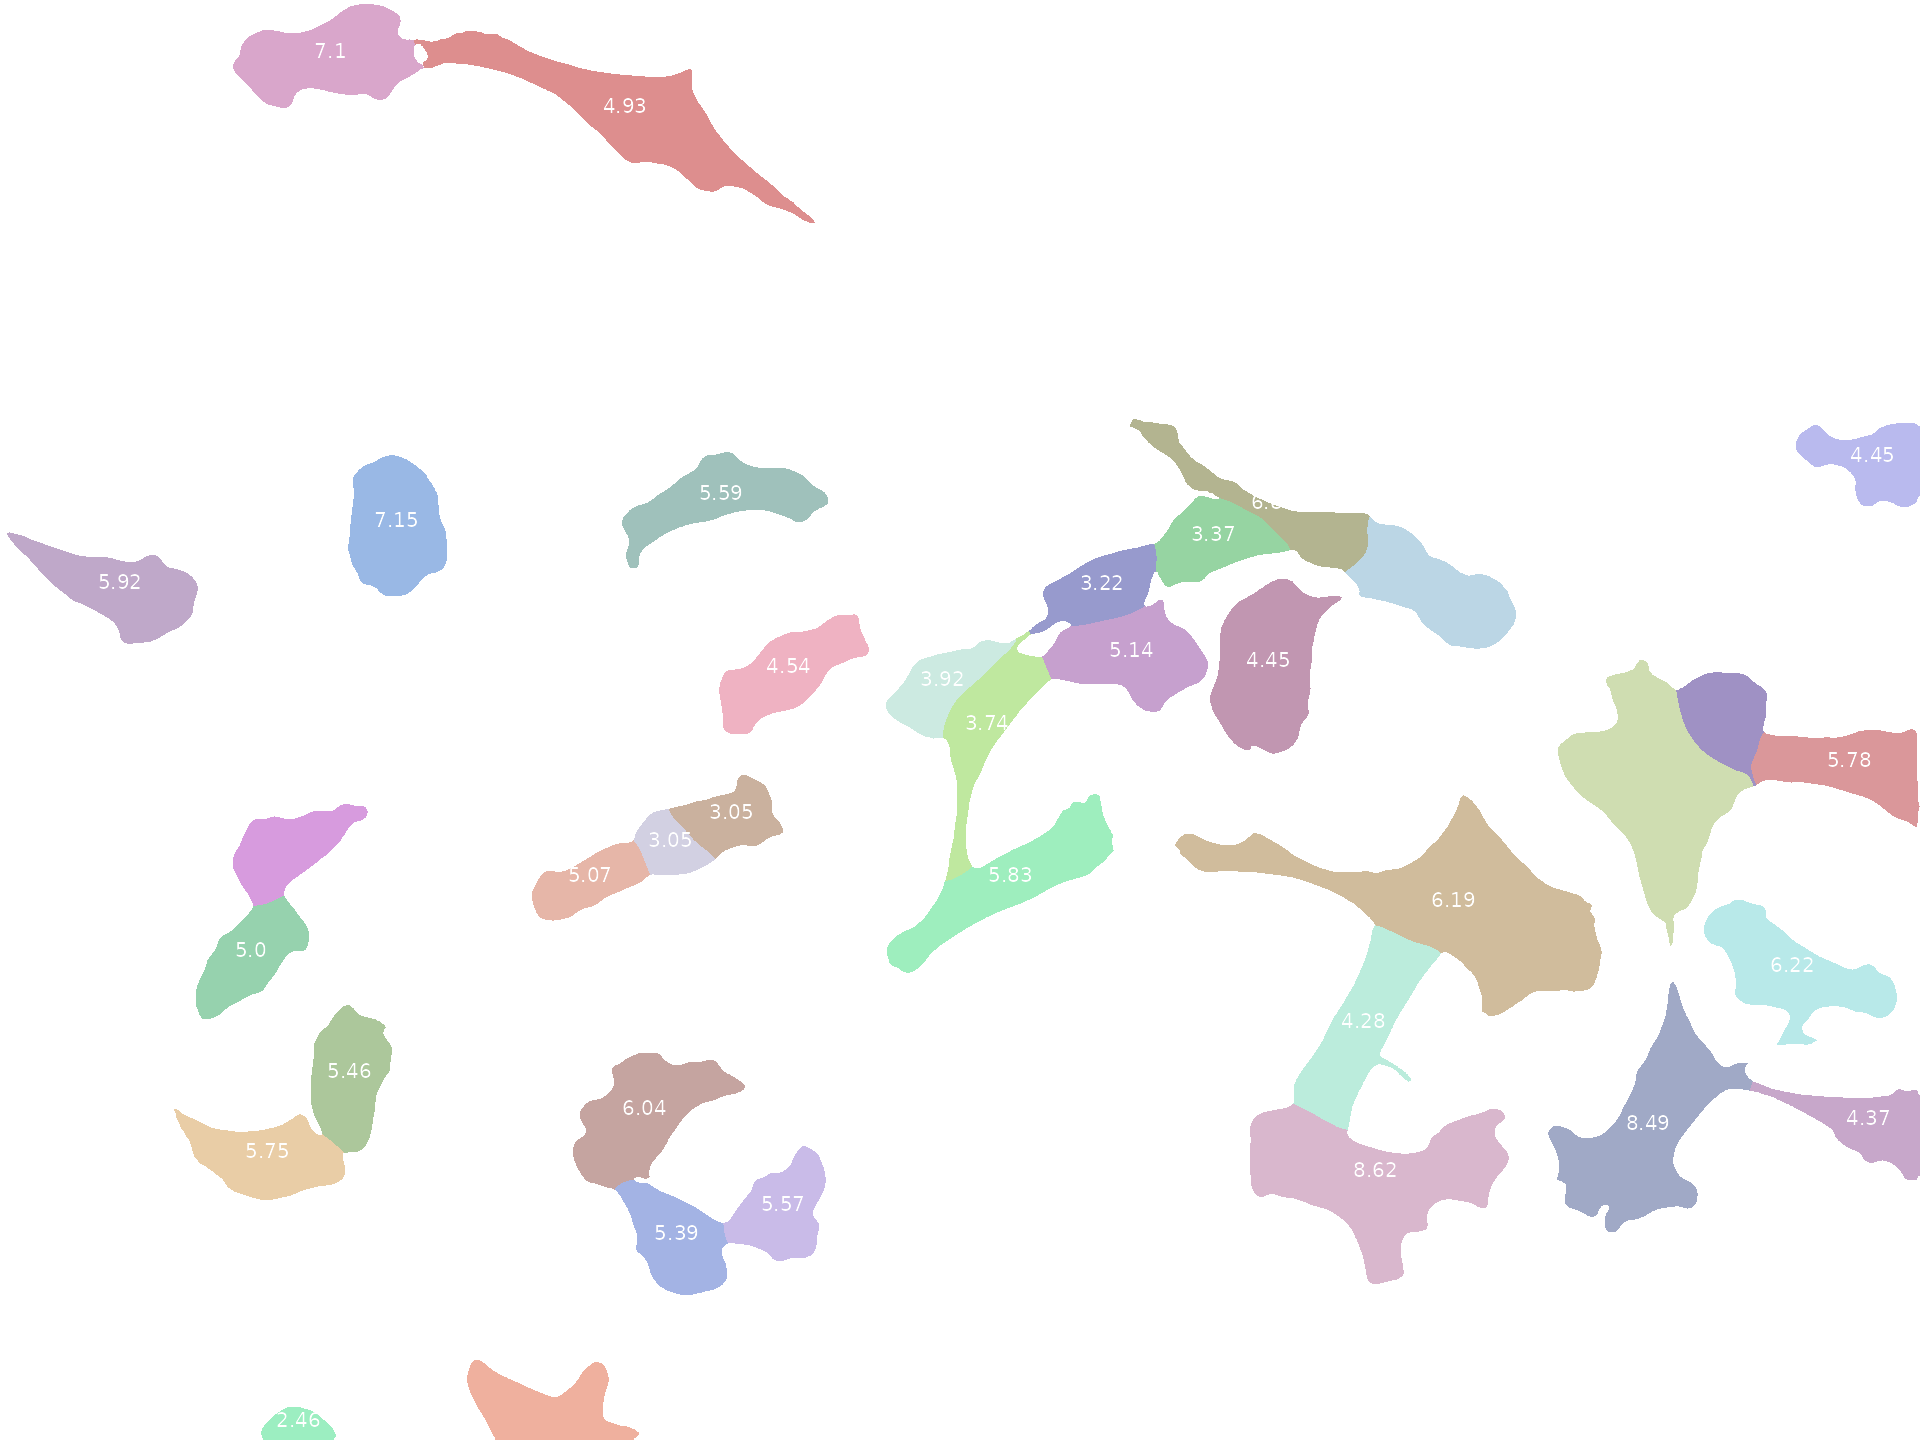

In [ ]:
### Ratio colormap for cyto/nuclei

im_cyto_ratio_masks = Image.fromarray(class_features.create_colormap_mask(masks_cyto))
im_cyto_ratio_labeled = class_features.image_labeling(im_mask=im_cyto_ratio_masks, im_labels=ratio_cells, coords=center_coords_ratio)
im_cyto_ratio_labeled

## Nuclei colormaps

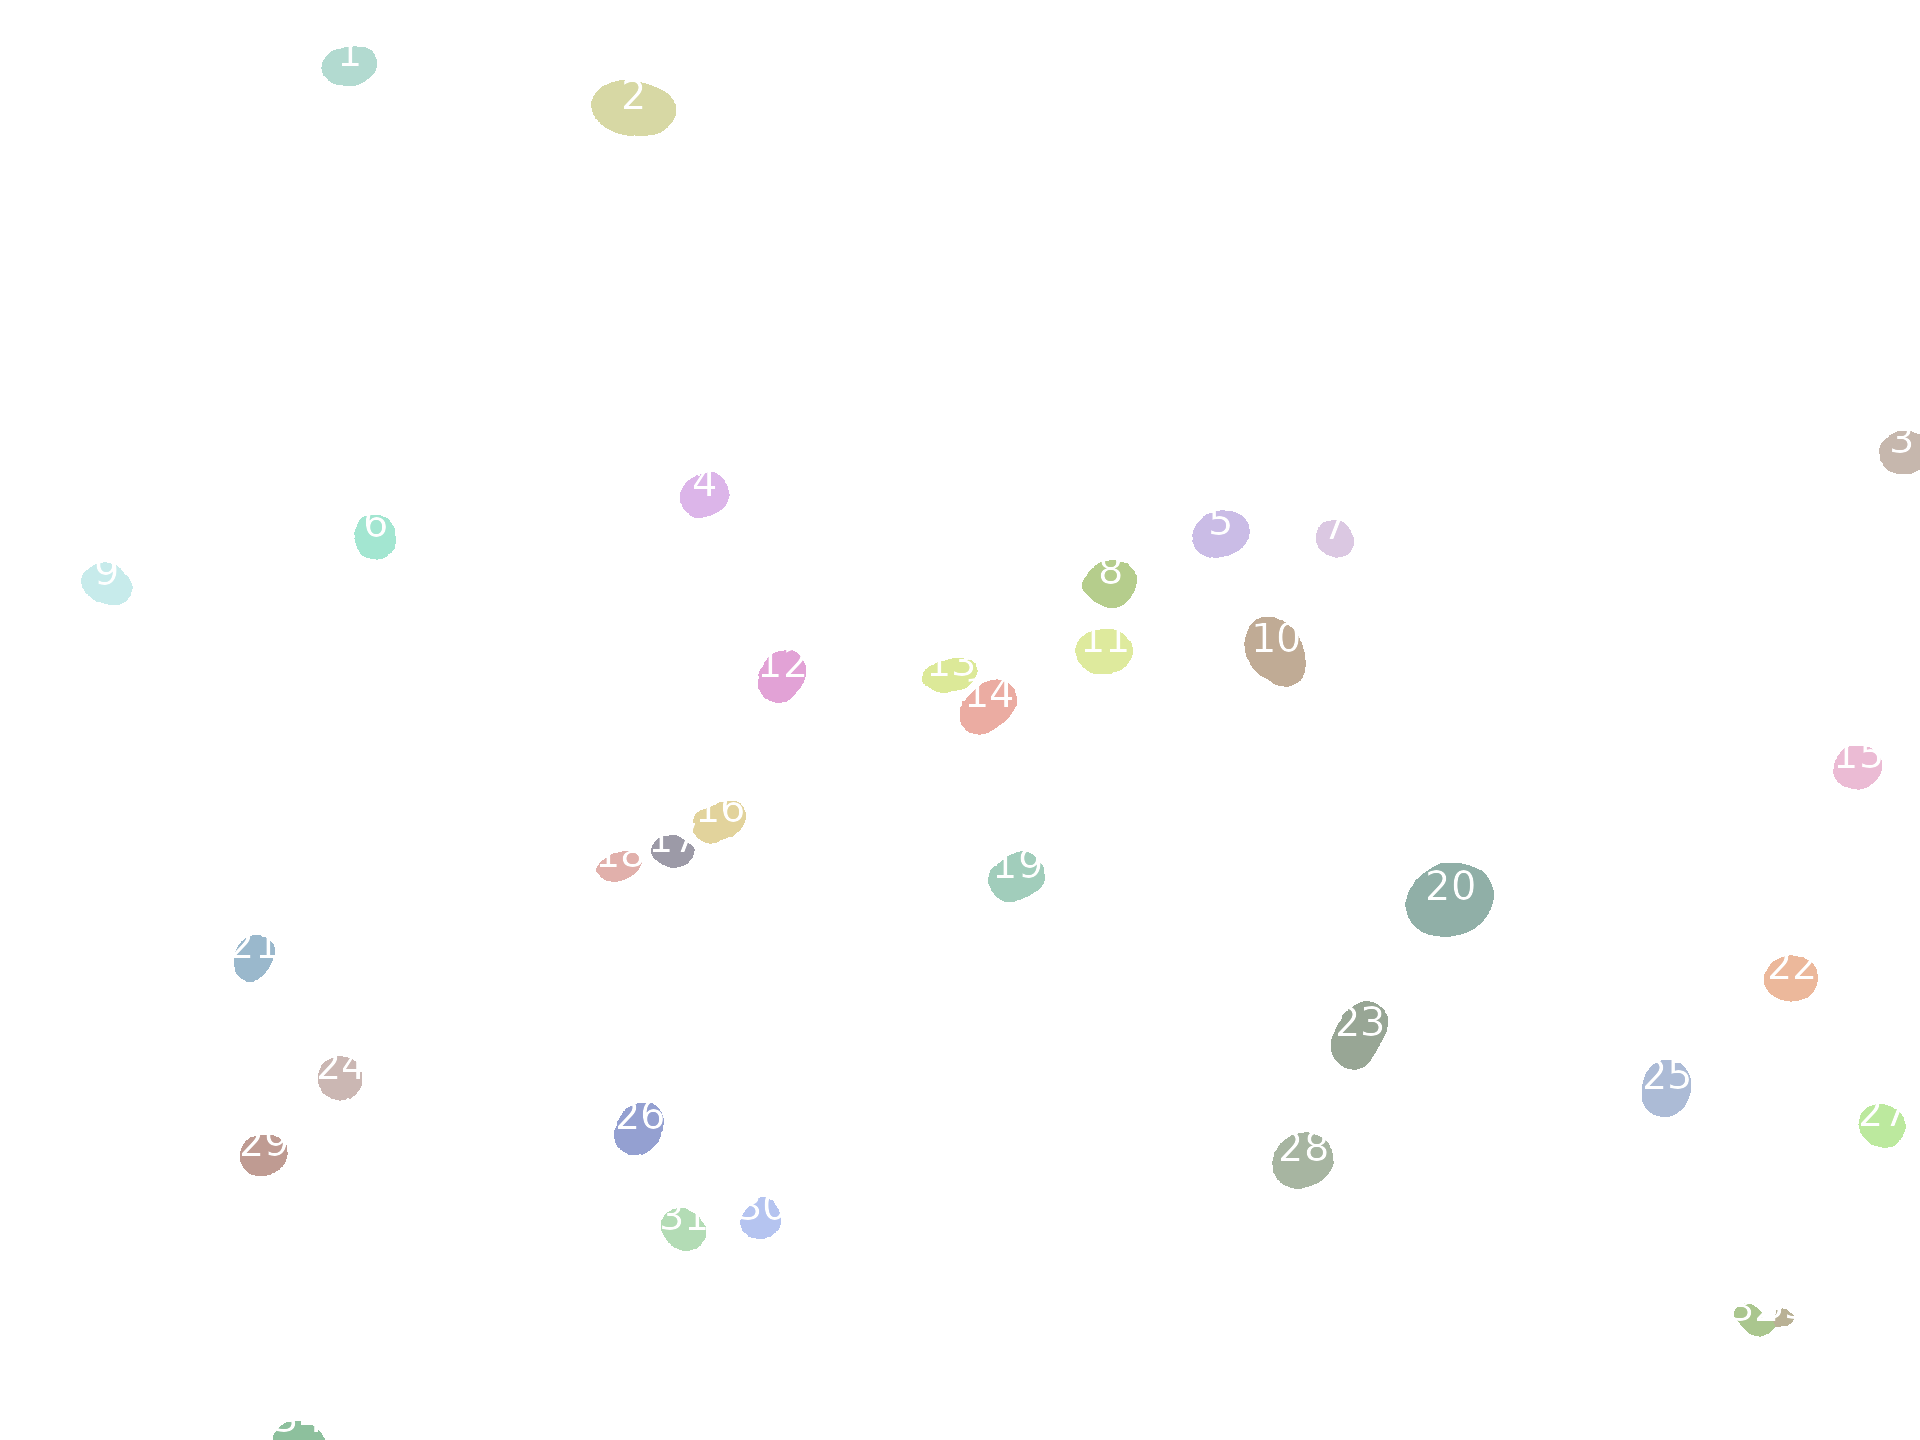

In [ ]:
### Index colormap for nuclei

nuclei_colormap_mask = Image.fromarray(class_features.create_colormap_mask(masks_nuclei))
im_nuclei_masks = class_features.mask_indexing(nuclei_colormap_mask, center_coords_secondary)
im_nuclei_masks

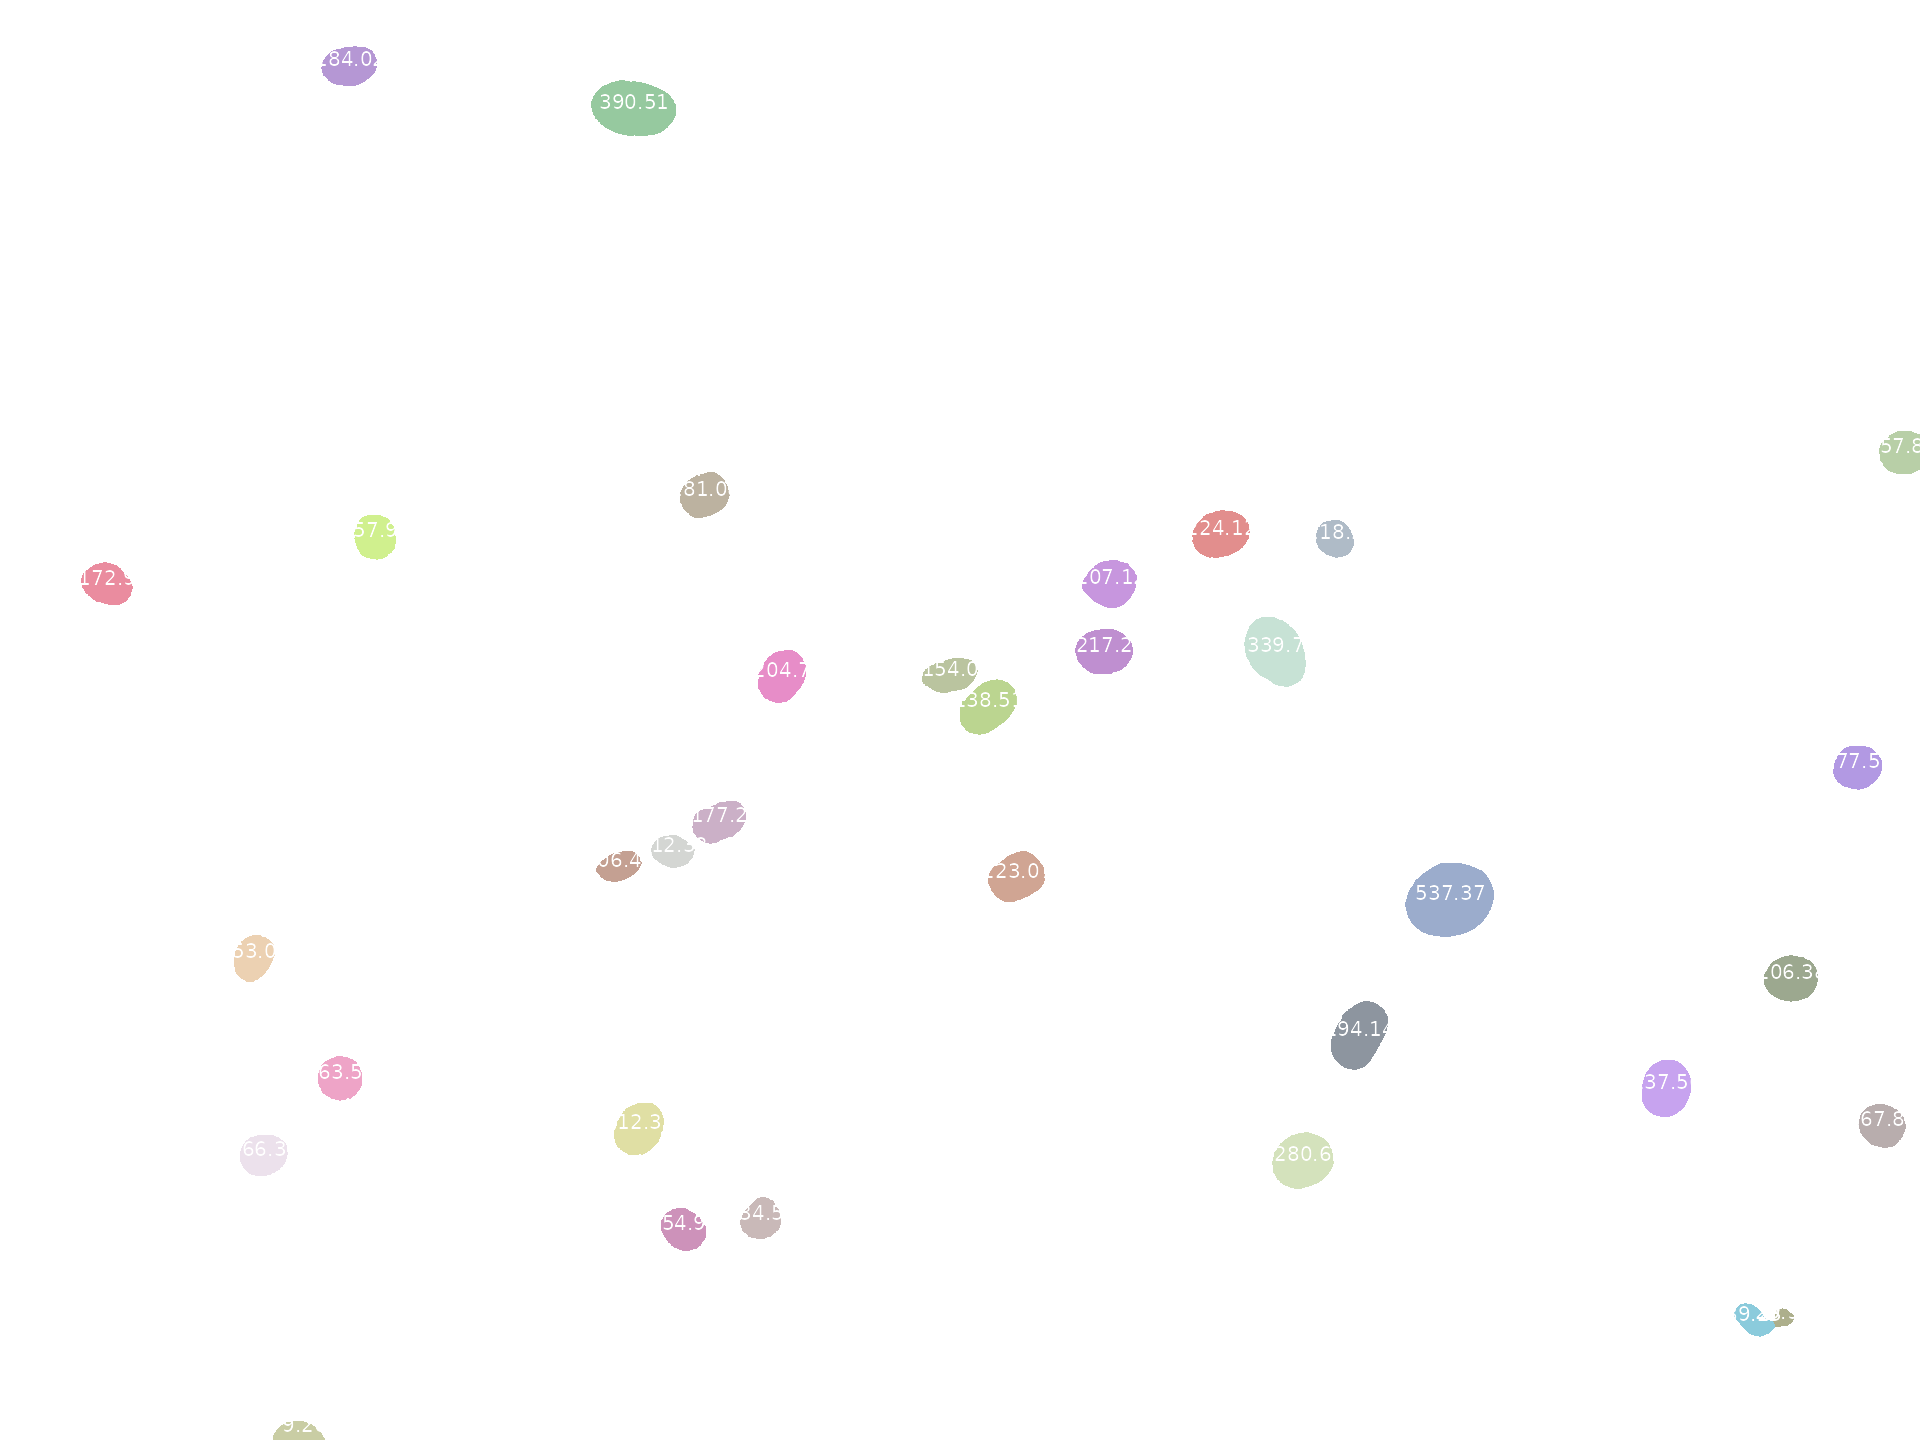

In [ ]:
### Area colormap for nuclei

im_nuclei_area_masks = Image.fromarray(class_features.create_colormap_mask(masks_nuclei))
im_nuclei_size_labeled = class_features.image_labeling(im_mask=im_nuclei_area_masks, im_labels=size_cells_secondary, coords=center_coords_secondary)
im_nuclei_size_labeled

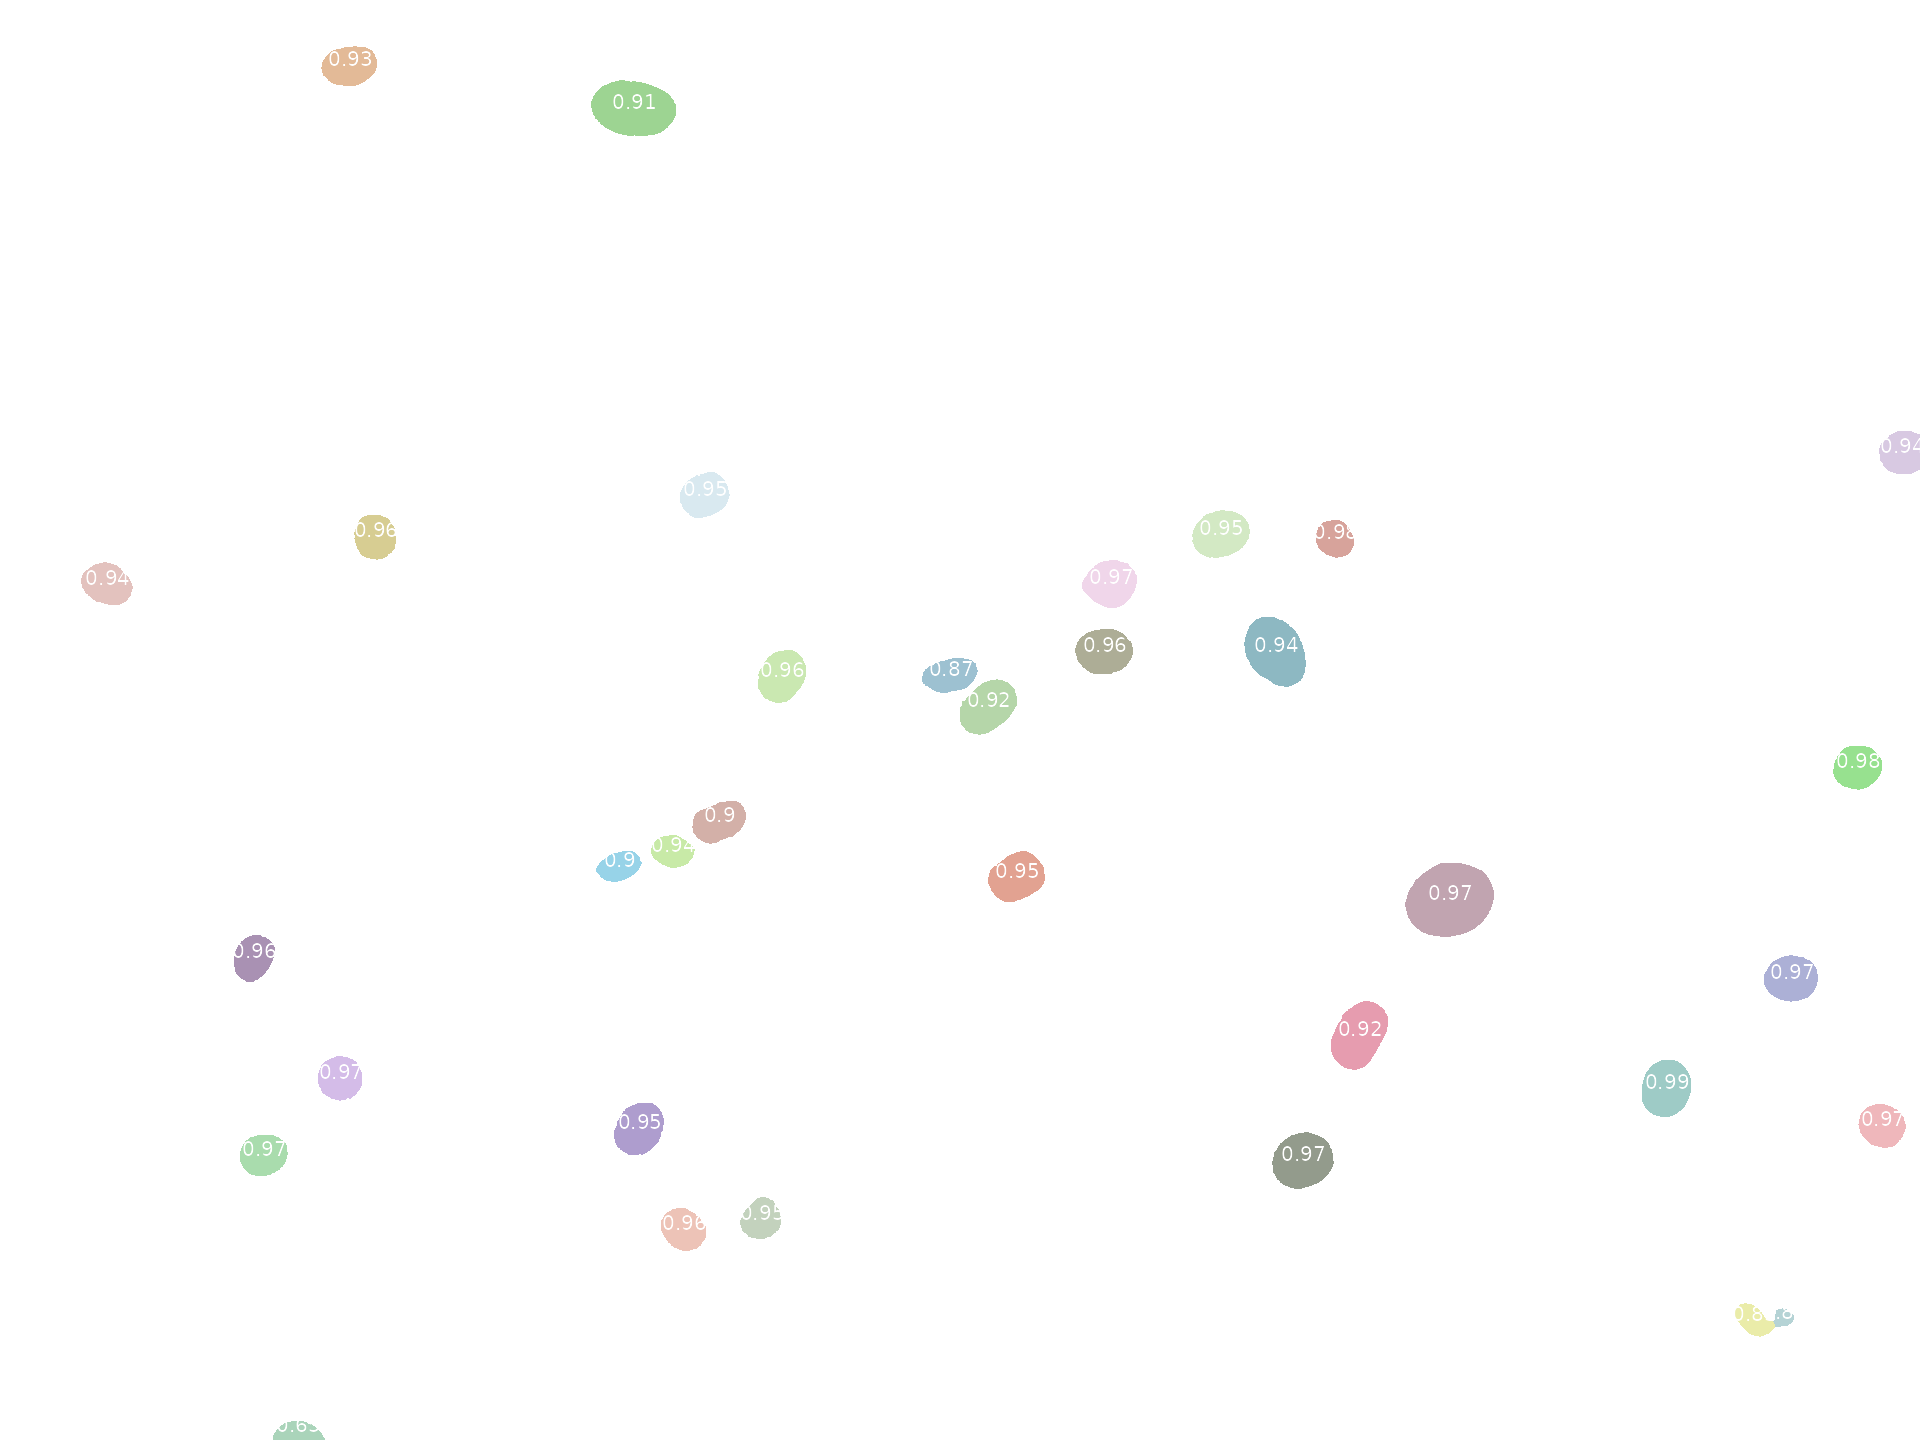

In [ ]:
### Roundness colormap for nuclei

im_nuclei_roundness_masks = Image.fromarray(class_features.create_colormap_mask(masks_nuclei))
im_nuclei_roundness_labeled = class_features.image_labeling(im_mask=im_nuclei_roundness_masks, im_labels=round_cells_secondary, coords=center_coords_secondary)
im_nuclei_roundness_labeled

# Voronoi analysis

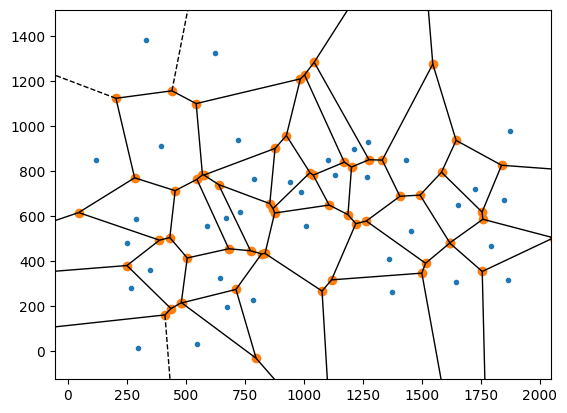

In [ ]:
### Voronoi diagram construction

center_coords_main = [[coord[0], 1440 - coord[1]] for coord in center_coords_main]
vor = Voronoi(center_coords_main)
fig = voronoi_plot_2d(vor)

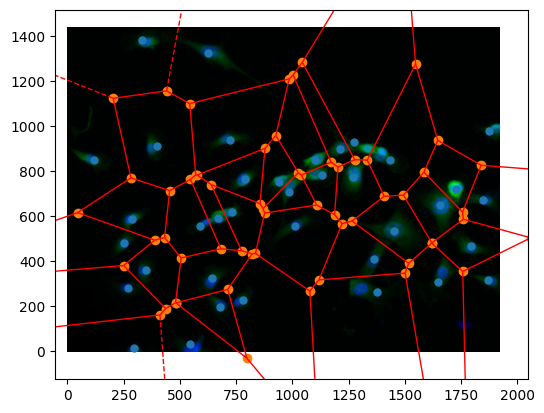

In [ ]:
fig, ax = plt.subplots()
ax.imshow(ndimage.rotate(np.fliplr(test_image), 180))
fig = voronoi_plot_2d(vor, point_size=10, ax=ax, line_colors='red')

# Save features

In [ ]:
### Create results folder and subfolders

results_dir = os.getcwd() + '/results'
if not os.path.exists(results_dir):
  os.makedirs(results_dir)

cyto_results_dir = results_dir + "/primary"
if not os.path.exists(cyto_results_dir):
  os.makedirs(cyto_results_dir)

nuclei_results_dir = results_dir + "/secondary"
if not os.path.exists(nuclei_results_dir):
  os.makedirs(nuclei_results_dir)

In [ ]:
### Save cyto images

im_cyto_masks.save(cyto_results_dir + "/primary_cyto_mask.png")
im_cyto_size_labeled.save(cyto_results_dir + "/primary_cyto_area.png")
im_cyto_roundness_labeled.save(cyto_results_dir + "/primary_cyto_roundness.png")
im_cyto_ratio_labeled.save(cyto_results_dir + "/primary_cyto_nuclei_ratio.png")
plt.savefig(cyto_results_dir + "/voronoi.png")

<Figure size 640x480 with 0 Axes>

In [ ]:
### Save nuclei images

im_nuclei_masks.save(nuclei_results_dir + "/secondary_nuclei_mask.png")
im_nuclei_size_labeled.save(nuclei_results_dir + "/secondary_nuclei_area.png")
im_nuclei_roundness_labeled.save(nuclei_results_dir + "/secondary_nuclei_roundness.png")

In [ ]:
### Save cyto csv files

np.savetxt(cyto_results_dir + "/area.csv",
           size_cells_main, delimiter=", ", fmt ='% s')

np.savetxt(cyto_results_dir + "/roundness.csv",
           round_cells_main, delimiter=", ", fmt ='% s')

indices_ratio = [class_features.out_concat(output_csv_ratio[idx], single_metric) for idx, single_metric in enumerate(ratio_cells)]
np.savetxt(cyto_results_dir + "/ratio.csv",
           indices_ratio, delimiter=", ", fmt ='% s')

np.savetxt(cyto_results_dir + "/voronoi_entropy.csv",
           [class_features.get_voronoi_entropy(vor)], delimiter=", ", fmt ='% s')

np.savetxt(cyto_results_dir + "/CSM.csv",
           symmetry.CSM_for_graph(vor), delimiter=", ", fmt ='% s')

In [ ]:
### Save cyto csv files

np.savetxt(nuclei_results_dir + "/area.csv",
           size_cells_secondary, delimiter=", ", fmt ='% s')
np.savetxt(nuclei_results_dir + "/roundness.csv",
           round_cells_secondary, delimiter=", ", fmt ='% s')